In [1]:
# 필요한 패키지들을 import한다.
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
# 현재 위치 경로를 확인한다.
os.getcwd()

'C:\\Users\\82104\\지능설'

In [3]:
# 글로벌 변수를 선언합니다.
# 나중에 convolution 연산 할 때 channel 정보가 필요하기 때문에
# data 파일에 있는 이미지의 크기를 미리 정해놓습니다.
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
# training_set 디렉토리에 강아지와 고양이 사진이 cat.xxxx.jpg 이런 형식으로
# 저장되어 있는데, 강아지와 고양이를 파일 이름으로 구분한다.
# 파일 이름명이 dog면 1을 cat이면 0을 뛰도록 dataframe에 저장해 놓는다.
filenames = os.listdir("./data/training_set")
categories =[]
for filename in filenames :
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head() # 데이터셋의 제일 앞 5개를 살펴본다.
# 파일 이름이 cat 이므로 category가 0으로 되어있다.

,filename,category
0,cat.1.jpg,0
1,cat.10.jpg,0
2,cat.100.jpg,0
3,cat.1000.jpg,0
4,cat.1001.jpg,0


In [6]:
df.tail() # 데이터 셋의 제일 뒤 5개를 살펴본다.
# 파일 이름이 dog 이므로 category가 1으로 되어있다.

,filename,category
8000,dog.995.jpg,1
8001,dog.996.jpg,1
8002,dog.997.jpg,1
8003,dog.998.jpg,1
8004,dog.999.jpg,1


<AxesSubplot:>

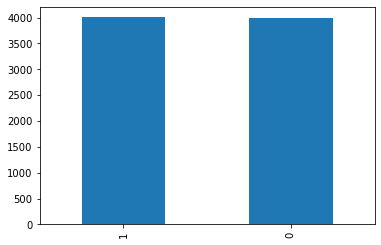

In [7]:
# 각 category별 데이터가 고루 분포되어 있어야 학습이 잘 되기 때문에
# dataframe 내에 강아지와 고양이가 균일하게 분포 되어 있는지를 확인한다.
df['category'].value_counts().plot.bar() 

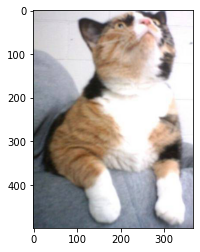

In [8]:
# 데이터 디렉토리 중 임의로 하나를 뽑아서 확인 한다.
# 사진을 랜덤으로 뽑다보면, 사진 크기가 각각 다른것을 알 수 있다.
sample=random.choice(filenames)
image = load_img("./data/training_set/"+sample)
plt.imshow(image)

In [9]:
# CNN 모델 개발
# CNN 구조는 작은 3*3 필터와 함께 MaxPooling 레이어가 뒤따르는 컨볼루션 레이어를
# 쌓는것을 포함한다. 레이어는 블록을 형성하고, 각 블록의 필터 수가 모델의 처음 4개
# 블록에 대해 32,64,128,256 과 같이 네트워크의 깊이에 따라 증가하며 반복된다.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# 드롭아웃은 데이터 샘플의 입력 변수 또는 이전 레이어의 활성화일 수 있는 레이어에 대한
# 입력을 확률적으로 제거하거나 삭제하여 작동한다.
# 아래 모델은 20%의 드롭아웃이 적용되고 모델의 분류가 부분에서 완전히 연결된 레이어
# 이후에 50%의 더 큰 드롭아웃 비율이 적용된다.
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 컨볼루션이나 맥스풀링을 하면서 주요특징이 추출되고 이런 작업은 이차원에서만 진행이 되지만
# fullyconnected layer로 넘겨주기 위해서는 2차원 자료를 1차원 자료로 변환하는 작업이
# 필요한데 이 때 사용하느 것이 flatten() 이다.
# 유닛을 가진 sigmoid로 연결한다.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# 0 또는 1 중 하나의 값을 예측하는 것이므로 노드가 1개이고
# 시그모이드 활성화가 있는 레이어가 사용된다.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# 개와 고양이의 이분법이기 때문에 loss 함수를 crossentropy로 설정한다.
# Metric은 학습 평가 기준을 말한다.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [10]:
# 조기종료와 학습율 하향조정을 위해 두 콜백 클래스를 import 한다.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
# Early stopping을 정의한다,
# Early stopping은 전체 데이터를 가지고 조금씩 나눠서 학습을 하는데
# 잘 학습하다가 어느시점이 지나면 정확도가 떨어지는 상황이 발생한다.
# 이때 10번까지 참다가 10번 지나도 떨어지면 학습을 그만하고 결과를 내라는 것이다.
earlystop = EarlyStopping(patience=10)

In [12]:
# 학습하는 동안 정확도를 잘 감시하고 있다가 어느 기준이 되면
# 학습률을 조정해주는 클래스이다.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience=2,
                                           vervose=0,
                                           factor=0.5,
                                           min_lr=0.00001)

In [13]:
# 앞에서 정의한 두 콜백 클래스를 callbacks에 담아둔다,
callbacks = [earlystop, learning_rate_reduction]

In [14]:
# 파일 이름에 강아지인지 고양이인지 저장해 놓은 dataframe에서
# category가 0인경우 고양이로 1인경우 강아지로 변경해준다.
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [15]:
# train_set 데이터중 20%를 쪼개서 학습중 파라미터 검증을 위한
# validation셋을 만들어 놓는다.
train_df, validate_df = train_test_split(df, test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

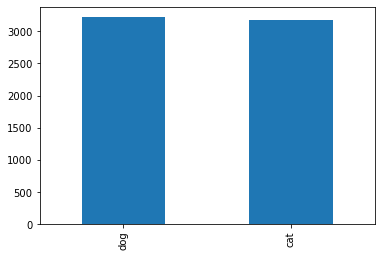

In [16]:
# train_set 의 분포를 확인한다.
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

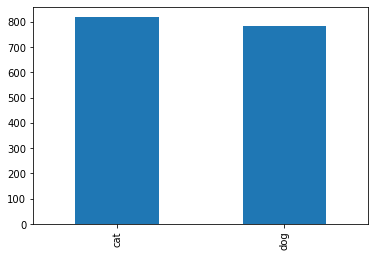

In [17]:
# 잘라낸 20% 데이터에도 강아지와 고양이의 분포를 확인한다.
validate_df['category'].value_counts().plot.bar()

In [18]:
# 학습데이터와 validation의 형상을 확인하고
# 한번에 학습할 batch의 size를 설정한다.
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [19]:
# 학습 데이터를 증강시킨다. (학습 데이터가 많을수록 잘 될 가능성이 크기 때문)
# 증강시키는 방법은 이미지를 약간 회전시키거나, 줌을 하거나, 상하,좌우 반전을 시킨다.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./data/training_set/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 6404 validated image filenames belonging to 2 classes.


In [20]:
# validation 이미지도 마찬가지로 이미지를 증강시킨다.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./data/training_set/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1601 validated image filenames belonging to 2 classes.


In [21]:
# 위에 데이터 증강이 잘 되었는지 확인하기 위한 증강을 실행한다.
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./data/training_set/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


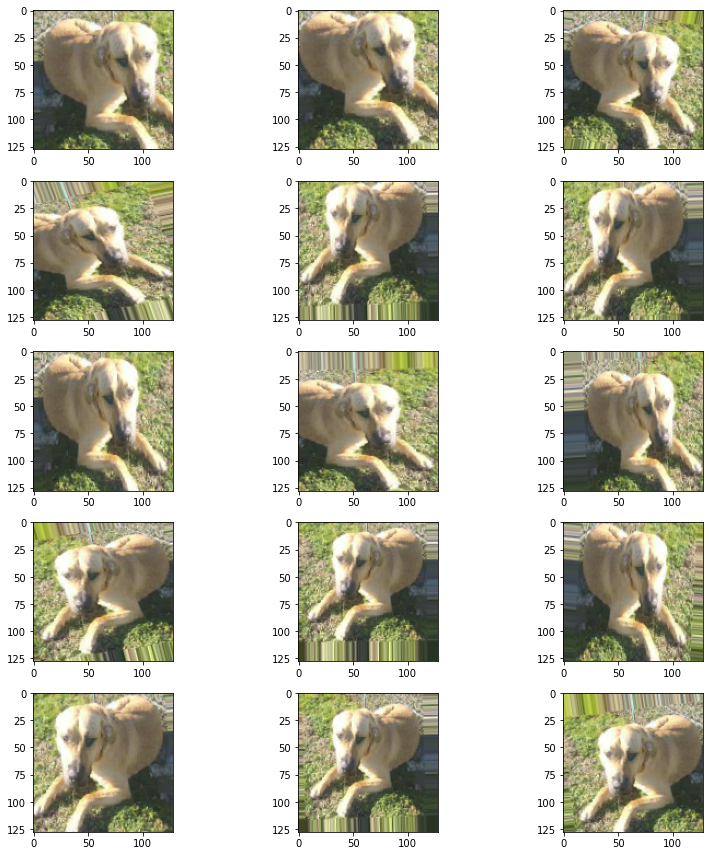

In [22]:
# 증강된 이미지를 확인해본다.
# 같은 이미지인데 좌우 반전이나 줌이 되어 있는것을 확인 할 수 있다.
plt.figure(figsize=(12,12))
for i in range(0,15) :
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator :
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
# 학습을 시작한다
# 1~13 에폭까지 학습을 하고, 중간에 collback이 일어나면 학습을 멈춘다.
# 케라스에서는 모델을 학습 시킬때, fit 을 사용한다.
# epoch을 이용해 전체 훈련 데이터 셋의 학습 반복 횟수를 지정한다.
epochs=3 if FAST_RUN else 13
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/13
426/426 [==============================] - 215s 497ms/step - loss: 0.0000e+00 - accuracy: 0.6212 - val_loss: 0.0000e+00 - val_accuracy: 0.5522 - lr: 0.0010
Epoch 2/13
426/426 [==============================] - 200s 470ms/step - loss: 0.0000e+00 - accuracy: 0.6784 - val_loss: 0.0000e+00 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 3/13
426/426 [==============================] - 200s 469ms/step - loss: 0.0000e+00 - accuracy: 0.6892 - val_loss: 0.0000e+00 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 4/13
426/426 [==============================] - 196s 460ms/step - loss: 0.0000e+00 - accuracy: 0.7048 - val_loss: 0.0000e+00 - val_accuracy: 0.6811 - lr: 5.0000e-04
Epoch 5/13
426/426 [==============================] - 197s 463ms/step - loss: 0.0000e+00 - accuracy: 0.7045 - val_loss: 0.0000e+00 - val_accuracy: 0.7201 - lr: 5.0000e-04
Epoch 6/13
426/426 [==============================] - 203s 476ms/step - loss: 0.0000e+00 - accuracy: 0.7117 - val_loss: 0.0000e+00 - val_accuracy: 0.7327 - l

In [24]:
# 학습한 모델을 저장한다.
model.save_weights("model.h5")

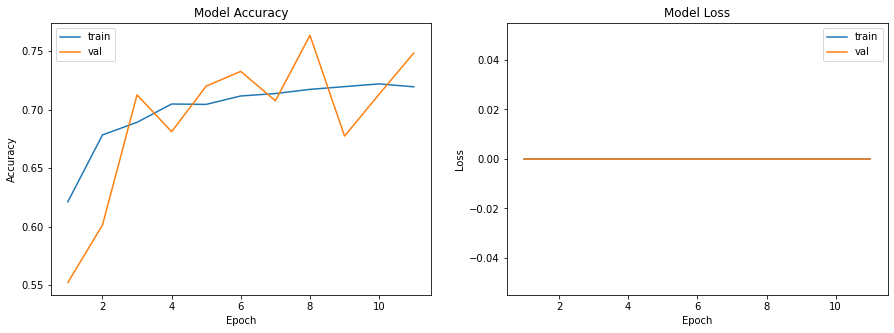

In [25]:
# 그동안 학습시킨 내용을 확인한다.
# 그래프를 보면 처음 학습 시점에는 정확도가 낮다가, 점점 올라가는 것을 볼 수 있다.
# 중간중간에 튀는 부분은 이미지가 정확하지 않거나 강아지 같이 생긴 고양이가 있어서
# 튀는 것 같다.
def plot_model_history(history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(history.history[acc])+1),history.history[acc])
    axs[0].plot(range(1,len(history.history[val_acc])+1),history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(history.history[acc])+1),len(history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [26]:
# 학습된 모델을 가지고 test 데이터를 맞춰본다
# test_set에 있는 강아지와 고양이 사진을 준비한다.
test_filenames = os.listdir("./data/test_set/") 
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

In [27]:
# 평가 데이터를 준비한다.
# test_set도 generator를 이용해서 만든다. 이전에 training_set도 1,/255로
# rescale 해주었기 때문에, test_set도 똑같이 rescale 해준다.
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./data/test_set/",
    x_col='filename',
    y_col=None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 2023 validated image filenames.


In [28]:
# 잘 저장되어 있는지 확인한다.
test_df

,filename
0,cat.4001.jpg
1,cat.4002.jpg
2,cat.4003.jpg
3,cat.4004.jpg
4,cat.4005.jpg
...,...
2018,dog.4996.jpg
2019,dog.4997.jpg
2020,dog.4998.jpg
2021,dog.4999.jpg


In [29]:
# 학습한 모델로 test_set을 넣어본다.
# threshold는 이미지의 픽셀값을 0또는 255로 만드는 연산이다.
# 원하는 피사체의 모양을 좀 더 정확히 판단 가능하고
# 배경과 물체를 구분한다.
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

135/135 [==============================] - 15s 109ms/step


In [30]:
# 편의성과 정확도 검증을 위해 개와 고양이일 확률중 보다 큰 값에
# 해당하는 레이블을 선택해서 값을 치환한다
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [31]:
# category가 0이면 cat 1이면 dog
test_df['category'] = test_df['category'].replace({0: 'cat', 1: 'dog'})

<AxesSubplot:>

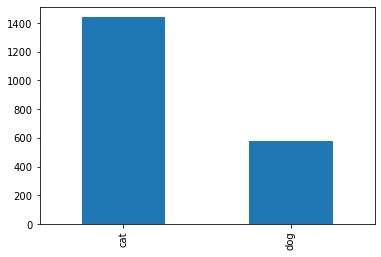

In [32]:
# 강아지와 고양이를 어느정도 예측했는지 확인한다.
test_df['category'].value_counts().plot.bar()

In [33]:
test_df

,filename,category
0,cat.4001.jpg,cat
1,cat.4002.jpg,cat
2,cat.4003.jpg,cat
3,cat.4004.jpg,cat
4,cat.4005.jpg,cat
...,...,...
2018,dog.4996.jpg,dog
2019,dog.4997.jpg,dog
2020,dog.4998.jpg,cat
2021,dog.4999.jpg,dog


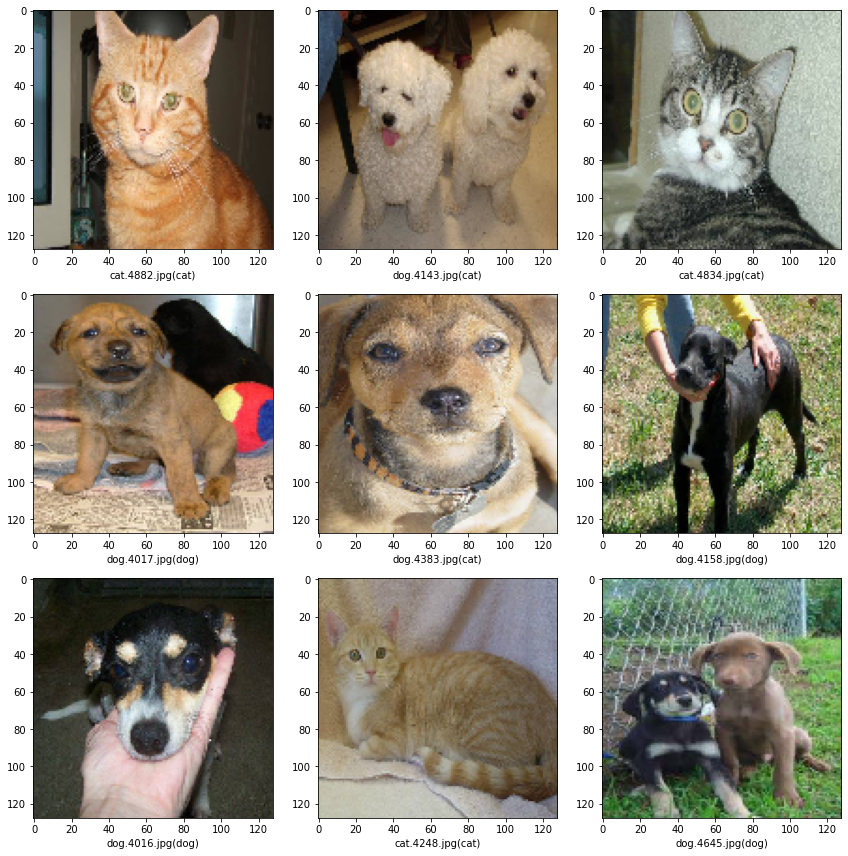

In [37]:
# 예측한 결과를 이미지와 함께 확인한다.
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12,12))
for index, row in sample_test.iterrows() :
    filename = row['filename']
    category = row['category']
    img = load_img("./data/test_set/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(3,3,index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()